In [10]:
import sys
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# 定义保存路径
save_dir = '/content/drive/My Drive/cnn_gan_model_directory/'

# 创建目录（如果不存在）
import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

class Discriminator(torch.nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = x.view(x.size(0), 784) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 784)
    def forward(self, x):
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image
        out = out.view(out.size(0), 1, 28, 28)
        return out


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST/',
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [12]:
from google.colab import files
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
D = Discriminator().to(device)
G = Generator().to(device)
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, device=device)


Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


In [13]:
def train_and_generate_images(G, D, num_rounds=200):
    # 标签定义
    lab_real = torch.ones(64, 1, device=device)
    lab_fake = torch.zeros(64, 1, device=device)
    # 储存损失值
    loss_D_list = []
    loss_G_list = []
    # 将数据加载器转换为迭代器
    dataloader_iter = iter(dataloader)
    model_count = 1  # 模型保存次数
    for epoch in range(num_rounds):  
        for i, data in enumerate(dataloader, 0):
            # STEP 1: 判别器优化步骤
            try:
                x_real, _ = next(dataloader_iter)
            except StopIteration:
                dataloader_iter = iter(dataloader)
                x_real, _ = next(dataloader_iter)

            x_real = x_real.to(device)
            batch_size = x_real.size(0)  # 动态获取批量大小
            lab_real = torch.ones(batch_size, 1, device=device)
            lab_fake = torch.zeros(batch_size, 1, device=device)
            optimizerD.zero_grad()
            D_x = D(x_real)
            lossD_real = criterion(D_x, lab_real)
            z = torch.randn(batch_size, 100, device=device)  # 随机噪声，64个样本，z_dim=100
            x_gen = G(z).detach()
            D_G_z = D(x_gen)
            lossD_fake = criterion(D_G_z, lab_fake)
            lossD = lossD_real + lossD_fake
            lossD.backward()
            optimizerD.step()
            # STEP 2: 生成器优化步骤
            optimizerG.zero_grad()
            z = torch.randn(batch_size, 100, device=device)  # 随机噪声，64个样本，z_dim=100
            x_gen = G(z)
            D_G_z = D(x_gen)
            lossG = criterion(D_G_z, lab_real)  # -log D(G(z))
            lossG.backward()
            optimizerG.step()
        loss_D_list.append(lossD.item())
        loss_G_list.append(lossG.item())
        print(epoch, lossD.item(), lossG.item())
        # 保存模型
        if epoch % 10 == 0:
            D_path = os.path.join(save_dir, f'discriminator_{model_count}.pth')
            G_path = os.path.join(save_dir, f'generator_{model_count}.pth')
            torch.save(D.state_dict(), D_path)
            torch.save(G.state_dict(), G_path)

        model_count += 1

    return loss_D_list, loss_G_list

In [14]:
loss_D_list, loss_G_list = train_and_generate_images(G, D)


0 0.6525262594223022 1.287320613861084
1 0.8648493885993958 1.1324132680892944
2 0.38071152567863464 1.7514965534210205
3 0.7397816181182861 1.4886225461959839
4 0.8524364233016968 1.4697794914245605
5 0.48964154720306396 1.9483908414840698
6 0.6643401384353638 1.4862022399902344
7 0.8158602714538574 1.6765682697296143
8 0.6987420916557312 1.8747144937515259
9 0.6628267765045166 1.5724551677703857
10 0.8452378511428833 1.734080195426941
11 0.8931065797805786 1.7334731817245483
12 0.7529046535491943 1.874398946762085
13 0.7401201725006104 1.8587216138839722
14 0.5633573532104492 1.8315925598144531
15 0.5857384204864502 2.2873597145080566
16 0.5460562705993652 1.573917269706726
17 0.6851449012756348 1.672628402709961
18 0.6872914433479309 2.0705299377441406
19 0.9155696630477905 1.9281548261642456
20 0.7562242746353149 1.985314130783081
21 0.7053866982460022 1.4719427824020386
22 1.000830888748169 1.3228302001953125
23 0.5801072120666504 1.7153408527374268
24 0.8981040716171265 1.6707636

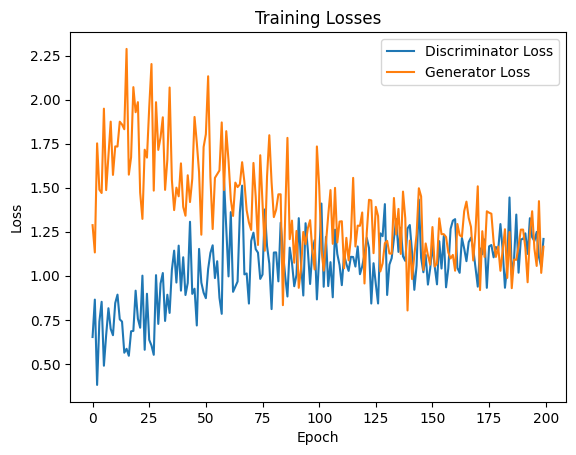

In [15]:
plt.plot(loss_D_list, label="Discriminator Loss")
plt.plot(loss_G_list, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.show()